<a href="https://colab.research.google.com/github/dowrave/Data_Analysis_Projects/blob/main/Dacon_total_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-optimize
!pip install keras-tuner

In [3]:
import pandas as pd
from pandas import CategoricalDtype
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from skopt import BayesSearchCV
import tensorflow as tf 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras_tuner
from tensorflow.keras import layers


pd.set_option('display.max_columns', None)

In [4]:
train = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/test.csv')

In [ ]:
train.head(2)

In [ ]:
train.info()

# 데이터 탐색

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'PaceTotal'}>,
        <AxesSubplot:title={'center':'ShootingTotal'}>,
        <AxesSubplot:title={'center':'PassingTotal'}>,
        <AxesSubplot:title={'center':'DribblingTotal'}>,
        <AxesSubplot:title={'center':'DefendingTotal'}>],
       [<AxesSubplot:title={'center':'PhysicalityTotal'}>,
        <AxesSubplot:title={'center':'Crossing'}>,
        <AxesSubplot:title={'center':'Finishing'}>,
        <AxesSubplot:title={'center':'HeadingAccuracy'}>,
        <AxesSubplot:title={'center':'ShortPassing'}>,
        <AxesSubplot:title={'center':'Volleys'}>,
        <AxesSubplot:title={'center':'Dribbling'}>,
        <AxesSubplot:title={'center':'Curve'}>],
       [<AxesSubplot:title={'center':'FKAccuracy'}>,
        <AxesSubplot:title={'center':'LongPassing'}>,
        <AxesSubplot:title={'center':'BallCon

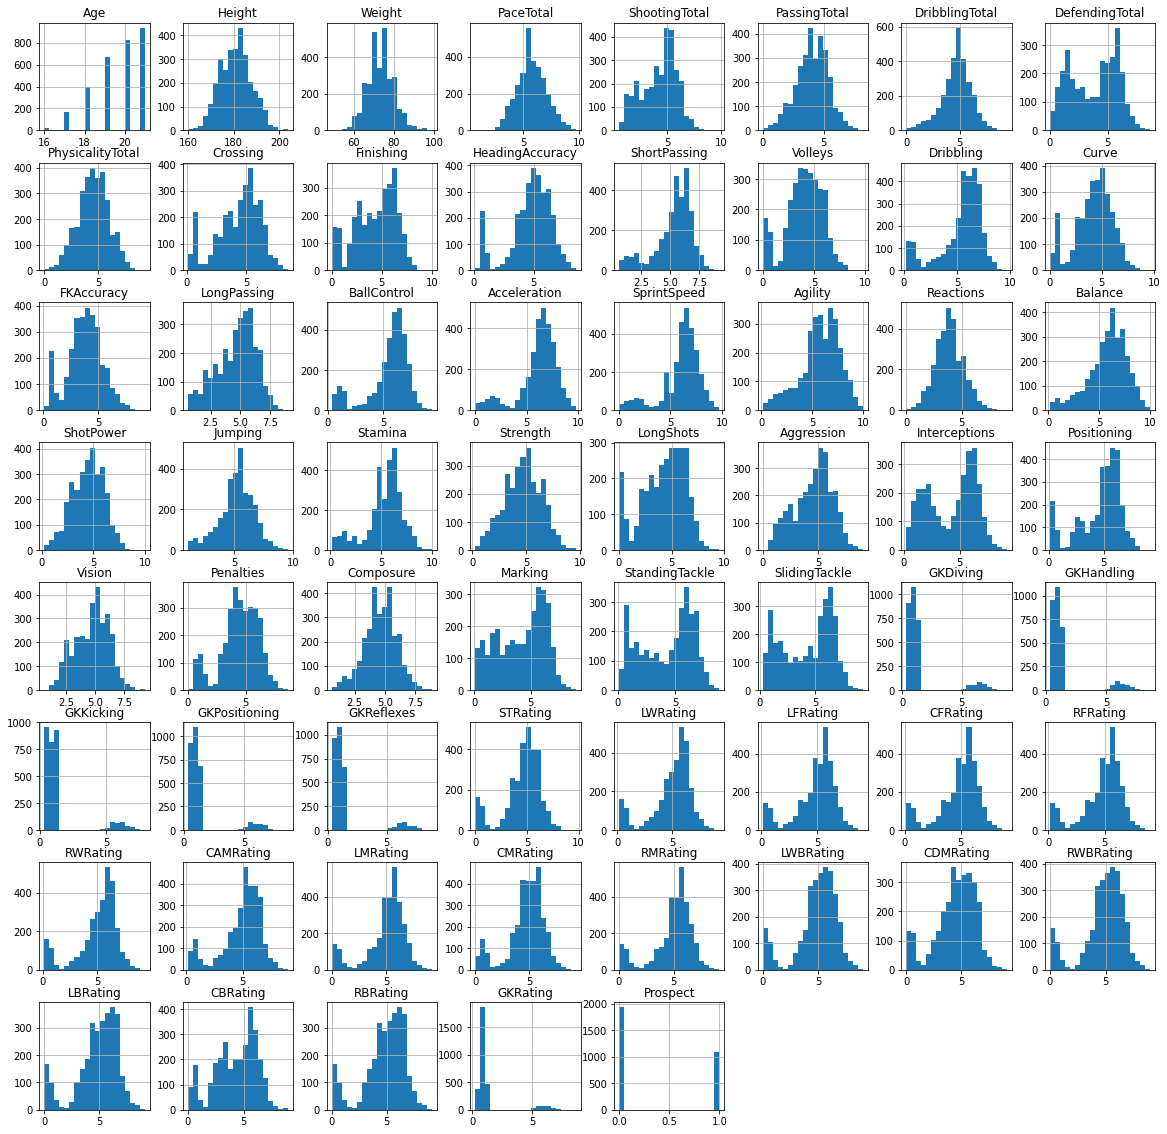

In [7]:
train.hist(bins = 20, figsize = (20, 20))

## 질적 데이터

- 전체 데이터 중 유망주의 비율 : $0.361$

In [8]:
train['Prospect'].sum() / train['Prospect'].count()

0.36104670420669094

#### 1. `PreferredFoot, WorkRate`
선요약 )  
- 특히 `WorkRate`의 경우는 높을수록 좋을 것이라는 생각을 하고 접근했지만, 가장 좋은 수치는 `Medium, Medium`에서 나왔음
- `PreferredFoot`의 경우 또한 `Left`에서 희소성이 있을 거라 생각하고 접근했지만, 그렇지는 않았음
- 둘 다 특별히 고칠 요소는 없는 것으로 보임


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 720x720 with 0 Axes>

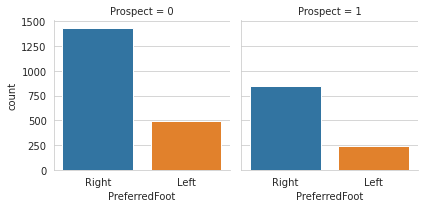

In [9]:
# 위 그래프는 이렇게 그려도 되지 않을까?
sns.set_style('whitegrid')
plt.figure(figsize = (10, 10))
grid = sns.FacetGrid(data = train, col = 'Prospect')
grid.map(sns.countplot, 'PreferredFoot', palette= 'tab10')

In [10]:
# 각 발 전체 인원 중 유망주 비율
print(train[(train['PreferredFoot'] == 'Left')
      & (train['Prospect'] == 1)]['ID'].count() / train[train['PreferredFoot'] == 'Left']['ID'].count(),
      train[(train['PreferredFoot'] == 'Right')
      & (train['Prospect'] == 1)]['ID'].count() / train[train['PreferredFoot'] == 'Right']['ID'].count(),
)
# 전체 인원 중 각 발의 비율
print(train[train['PreferredFoot'] == 'Left']['ID'].count() / train['ID'].count(),
      train[train['PreferredFoot'] == 'Right']['ID'].count() / train['ID'].count(),
)
# 유망주 전체 인원 중 각 발의 비율
print(train[(train['PreferredFoot'] == 'Left')
      & (train['Prospect'] == 1)]['ID'].count() / train[train['Prospect'] == 1]['ID'].count(),
      train[(train['PreferredFoot'] == 'Right')
      & (train['Prospect'] == 1)]['ID'].count() / train[train['Prospect'] == 1]['ID'].count(),
)

0.3333333333333333 0.36996497373029774
0.24345809870818153 0.7565419012918185
0.22477064220183487 0.7752293577981652


1. 각 발에 대해 전체 인원 중 유망주 비율
- 왼발 : $0.33$
- 오른발 : $0.37$

2. 전체 인원과 각 발의 비율
- 왼발 : $0.24$
- 오른발 : $0.75$

3. 유망주 전체 인원과 각 발의 비율
- 왼발 : $0.22$
- 오른발 : $0.78$

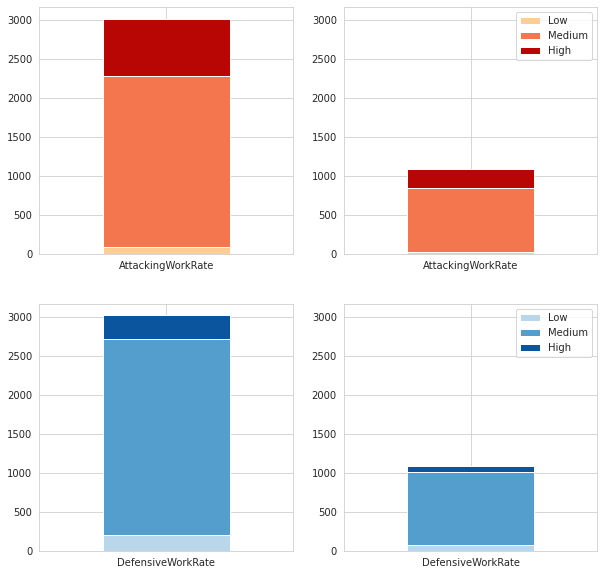

In [11]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

for i, val in enumerate(['AttackingWorkRate', 'DefensiveWorkRate']):
  if i == 0:
    color = np.array(sns.color_palette('OrRd'))[[1, 3, 5], :]
  elif i == 1:
    color = np.array(sns.color_palette('Blues'))[[1, 3, 5], :]
  
  (train[val].value_counts()[['Low', 'Medium', 'High']]
                          .to_frame()
                          .T
                          .plot(kind = 'bar', 
                                stacked = True, 
                                rot = 0,
                                ax = ax[i][0],
                                color = color)
                          )
  ax[i][0].legend().set_visible(False)

  (train[train['Prospect'] == 1][val].value_counts()[['Low', 'Medium', 'High']]
                                                  .to_frame()
                                                  .T
                                                  .plot(kind = 'bar', 
                                                        stacked = True, 
                                                        rot = 0,
                                                        ax = ax[i][1],
                                                        color = color
  ))

  ax[i][1].set_ylim(ax[i][0].get_ylim())

In [12]:
# 위 사항은 수치적으로 보고 싶음 : WorkRate에는 총 9가지 유형이 있는데, 이에 따른 생존율을 비교해보자
temp = (train[['ID', 'AttackingWorkRate', 'DefensiveWorkRate', 'Prospect']]
                                                              .groupby(['AttackingWorkRate', 'DefensiveWorkRate', 'Prospect'])['ID']
                                                              .count()
                                                              .to_frame()
                                                              .reset_index().rename(columns = {"ID" : 'counts'})
)
temp.head(2)

,AttackingWorkRate,DefensiveWorkRate,Prospect,counts
0,High,High,0,81
1,High,High,1,20


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


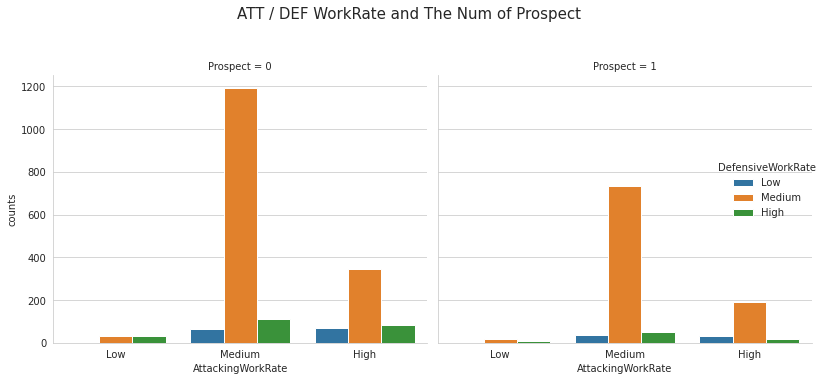

In [13]:
sns.catplot(data = temp, 
            x = 'AttackingWorkRate', 
            y = 'counts', 
            hue = 'DefensiveWorkRate', 
            col = 'Prospect', 
            kind = 'bar', 
            order = ['Low', 'Medium', 'High'], 
            hue_order = ['Low', 'Medium', 'High'],
            ax = ax)
plt.suptitle("ATT / DEF WorkRate and The Num of Prospect", y = 1.05, fontsize = 15)
plt.tight_layout()

In [14]:
temp['rates'] = temp['counts'] / temp.groupby(['AttackingWorkRate', 'DefensiveWorkRate'])['counts'].transform("sum")
temp_hm = temp[temp['Prospect'] == 1][:]
temp_hm = temp_hm.pivot(index = 'AttackingWorkRate', columns = 'DefensiveWorkRate', values = 'rates').loc[['High', 'Medium', 'Low'], ['Low', 'Medium', 'High']]

Text(0.5, 1.0, 'Att / Def WorkRate and Prospect Rate')

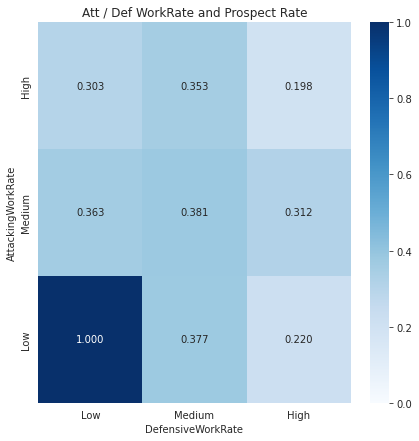

In [15]:
plt.figure(figsize = (7, 7))
sns.heatmap(data = temp_hm, annot = True, fmt = '.3f', cmap = 'Blues', vmin = 0, vmax = 1)
plt.title("Att / Def WorkRate and Prospect Rate")

- `Low, Low`에 있는 요소는 샘플이 1개니까 크게 고려할 요소는 아님
- 애초에 예상한 건 `오른쪽 위로 갈수록 활동량이 좋으니 Prospect 비율이 높을 것이다` 였는데, 그렇지는 않은 것으로 나타남

#### 2. `Position`

In [16]:
train['Position'].unique()

array(['CB', 'ST', 'RB', 'LB', 'GK', 'CDM', 'CAM', 'CM', 'RM', 'LM',
       'RWB', 'LWB', 'RW', 'CF', 'LW'], dtype=object)

In [17]:
# 먼저 시각화 하고 시작함
position_order = ['GK', 'LB', 'CB', 'RB', 'LWB', 'CDM', 'RWB', 'LM', 'CM', 'RM', 'CAM', 'LW', 'CF', 'RW', 'ST']
pos = (train[['Position', 'Prospect']].value_counts()
                                .to_frame()
                                .reset_index()
                                .rename(columns = {0 : 'counts'})
                                .pivot(index = 'Position', 
                                       columns = 'Prospect', 
                                       values = 'counts')
                                .loc[position_order]
    )
pos

Prospect,0,1
Position,,
GK,187.0,127.0
LB,88.0,30.0
CB,340.0,194.0
RB,106.0,33.0
LWB,40.0,16.0
CDM,103.0,41.0
RWB,46.0,15.0
LM,82.0,52.0
CM,89.0,40.0


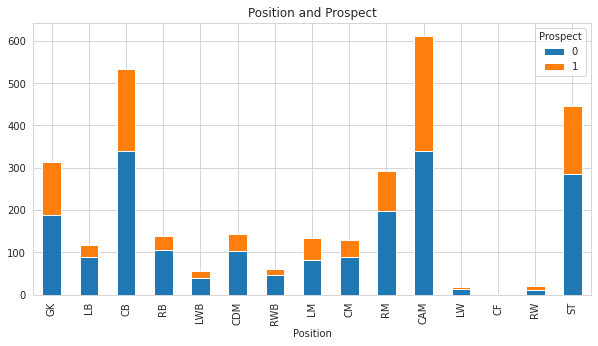

In [18]:
fig, ax = plt.subplots(figsize = (10, 5))
pos.plot(kind = 'bar', stacked = True, ax = ax)
ax.set_title("Position and Prospect")
ax.set_axisbelow(True)
plt.grid(True, axis = 'y')

- CAM, CB, ST, GK, RM 순으로 데이터의 양이 많음
- CF, LW, RW는 정말 적은 양을 차지함
  - 그러나 0과 1에 대한 label이 모두 있기 때문에 포지션에서 배제하지는 않겠음

## 양적 데이터

<AxesSubplot:>

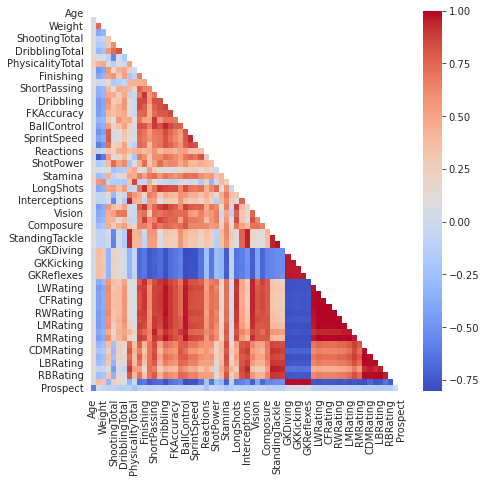

In [19]:
plt.figure(figsize = (7, 7))

corr = train.corr()
mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True # 원래 행렬의 윗부분 절반을 1로 만드는 것

sns.heatmap(data = corr, cmap = 'coolwarm', mask = mask) 

- 위 히트맵에서, 일부 필요없는 부분을 제외하고 시각화 함
- 보고 싶은 건 2가지임
  1. 각종 스탯 간의 관계
  2. 각종 스탯과 `Position Rating`의 관계
- 또한, 

In [20]:
border = train.corr().columns.get_loc('GKReflexes') + 1 # 47

<AxesSubplot:>

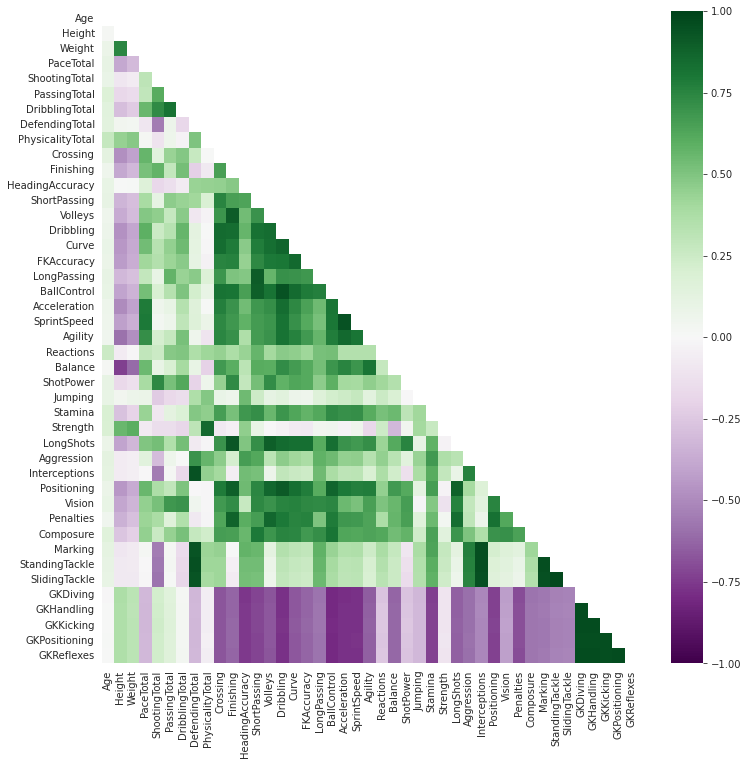

In [21]:
# 1. 스탯 간의 관계 보기

# 근데 그냥 0 이상으로 두는게 낫지 않을까 싶으요?
# 요건 솔직히 어떻게 해놔야 될지 모르겠다. 다음에 보도록 하자.
corr1 = train.corr().iloc[:border, :border]
mask = np.zeros_like(corr1, dtype = bool)
mask[np.triu_indices_from(mask)] = True # 원래 행렬의 윗부분 절반을 1로 만드는 것


plt.figure(figsize = (12, 12))
sns.heatmap(data = corr1, 
            cmap = 'PRGn', 
            mask = (mask 
                   # | np.where(corr1 > 0.5, 0, 1)
                    ), 
            vmin = -1, 
            vmax = 1) 

- 전체적으로 봤을 때, 모든 값을 모델에 포함한다면 중복되는 영역이 생김
  - 예를 들면 ~~Total에 들어가는 값에는 중복이 있을 것
  - 또한 `Rating`에 대한 수치도 중복이 있을 것이다

<AxesSubplot:>

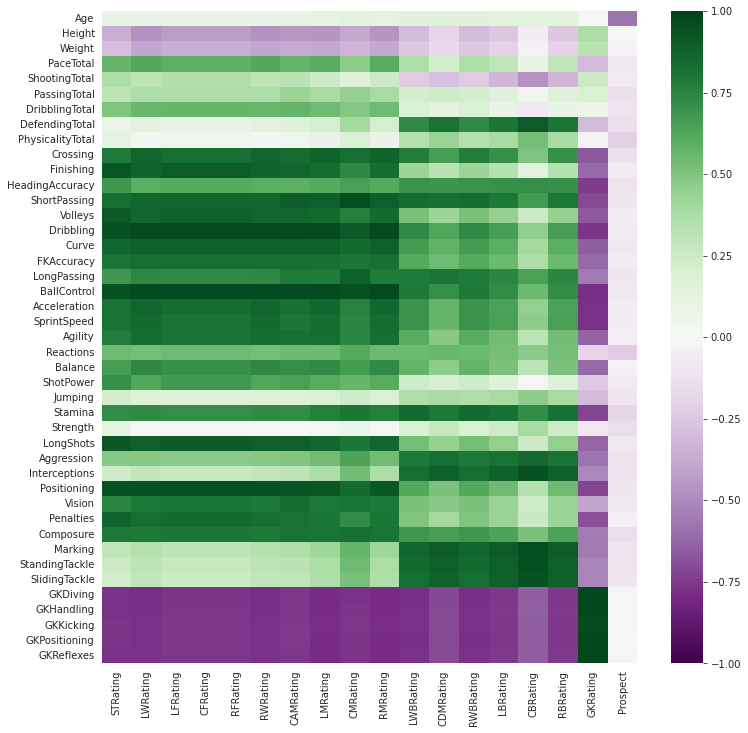

In [22]:
corr2 = train.corr().iloc[:border, border:]
# mask = np.zeros_like(corr2, dtype = bool)
# mask[np.triu_indices_from(mask)] = True # 원래 행렬의 윗부분 절반을 1로 만드는 것

plt.figure(figsize = (12, 12))
sns.heatmap(data = corr2, 
            cmap = 'PRGn', 
            # mask = np.where(corr2 > 0.3, 0, 1),
            vmin = -1, 
            vmax = 1) 

- 이렇게 놓고 봤을 때 명백히 나뉘는 구역이 3가지가 있음
  - `LM, CM, RM` 영역 및 이보다 공격적인 위치
  - `LWB, CDM, RWB` 영역 ~ 수비수 영역까지 수비적인 위치
  - `GK`
- 이렇게 나눠지는 영역에서도 `CM`이나 `CDM`은 다른 경향을 보임


In [23]:
foot_order = ['Left', 'Right']
work_rate_order = ['Low', 'Medium', 'High']

def column_label_order(df, col, order_lst):

  LE = LabelEncoder()
  LE.fit(df[col])
  LE.classes_ = np.array(order_lst)
  df[col] = LE.transform(df[col])


column_label_order(train, 'PreferredFoot', foot_order)
column_label_order(train, 'AttackingWorkRate', work_rate_order)
column_label_order(train, 'DefensiveWorkRate', work_rate_order)

In [24]:
train.columns

Index(['ID', 'Age', 'Height', 'Weight', 'Position', 'PreferredFoot',
       'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'STRating',
       'LWRating', 'LFRating', 'CFRating', 'RFRating', 'RWRating', 'CAMRating',
       'LMRating', 'CMRating', 'RMRating', 'LWBRating', 'CDMRating',
       'RWBRating', 'LBRating', 'CBRating', 'RBRating', 'GKRating',
       'Prospect'],
      dtype='o

In [25]:
train_ab = train.iloc[:, np.r_[0: train.columns.get_loc('DefensiveWorkRate') + 1, train.columns.get_loc('Crossing') : train.columns.get_loc('GKReflexes') + 1, -1]]
train_ab.head(2)

,ID,Age,Height,Weight,Position,PreferredFoot,AttackingWorkRate,DefensiveWorkRate,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Prospect
0,TRAIN_0000,21,182,82,CB,1,1,1,4.8864,2.4176,6.7045,5.1807,1.8391,5.1087,2.7586,1.8889,5.3571,5.7303,4.8193,6.0976,5.0000,4.5312,5.3333,4.8684,6.8493,6.6667,6.4789,2.0690,5.7647,6.4773,4.8936,3.8095,4.5349,5.3012,6.7416,6.7816,6.6667,0.9091,0.7955,0.3297,0.7865,0.9091,0
1,TRAIN_0001,21,160,75,ST,0,2,1,4.5455,7.6923,6.2500,5.4217,6.5517,7.3913,6.4368,5.2222,4.5238,5.8427,8.4337,7.1951,6.9737,6.4062,8.8000,6.9737,6.8493,7.4074,7.0423,7.5862,3.7647,3.7500,7.1277,6.4286,8.6047,6.1446,2.8090,3.3333,2.9762,1.2500,1.1364,0.6593,0.6742,1.3636,0


In [26]:
train_ab_avg = (train_ab.iloc[:, 1:].groupby(['Position', 'Prospect'])
                                    .mean()
                                    .reset_index()
                                    .set_index(['Position', 'Prospect'])
                                    .T
                )
train_ab_avg.head(2)

Position         CAM                      CB                     CDM  \
Prospect           0           1           0           1           0   
Age        20.055882   18.441176   20.185294   18.731959   20.184466   
Height    177.120588  177.102941  185.991176  186.252577  179.786408   

Position                 CF          CM                   GK              \
Prospect           1      0           0        1           0           1   
Age        18.756098   19.5   20.202247   19.150   20.085561   18.874016   
Height    180.804878  178.5  179.494382  179.625  187.893048  188.724409   

Position          LB                 LM                      LW              \
Prospect           0      1           0           1           0           1   
Age        20.352273   18.7   20.134146   19.057692   20.583333   18.666667   
Height    178.284091  178.5  176.756098  176.211538  174.500000  178.166667   

Position      LWB                    RB                      RM              \
Prospect        0         1           0           1           0           1   
Age        20.550   18.7500   20.141509   18.545455   20.262626   18.829787   
Height    179.025  178.4375  178.367925  177.727273  176.429293  176.180851   

Position          RW                     RWB                      ST  \
Prospect           0           1           0           1           0   
Age        20.000000   18.333333   20.108696   18.533333   20.203509   
Height    173.727273  173.000000  177.695652  176.066667  182.575439   

Position              
Prospect           1  
Age        18.534161  
Height    182.211180

- 위 표를 보면 가장 의외인 지점은, 같은 포지션에서도 `Prospect = 0`의 스탯이 더 높은 수치를 나타내는 곳이 많다.
- `Age`는 `Prospect`를 결정하는 중요한 요인이라고 생각됨.

<AxesSubplot:xlabel='Age', ylabel='count'>

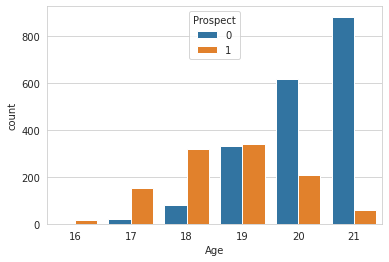

In [27]:
sns.countplot(data = train, x = 'Age', hue = 'Prospect')

## 중복을 생각해 배제했던 Rating이나 Total에 대한 정보 보기



### 1. Rating
- 선수의 주 포지션과 주 포지션 레이팅, 유망 여부의 df를 따로 분리해서 보겠음
  - 즉 자기 포지션의 레이팅과 유망 여부가 관련이 있는가를 보는 것

In [28]:
train['Position'].unique()

array(['CB', 'ST', 'RB', 'LB', 'GK', 'CDM', 'CAM', 'CM', 'RM', 'LM',
       'RWB', 'LWB', 'RW', 'CF', 'LW'], dtype=object)

In [29]:
pos_rat = train.iloc[:, np.r_[0, 4, train.columns.get_loc('STRating') : train.columns.get_loc('Prospect') + 1]]
GK = pos_rat[pos_rat['Position'] == 'GK'][['ID', 'Position', 'GKRating', 'Prospect']].rename(columns = {'GKRating' : 'POSRating' })
ST = pos_rat[pos_rat['Position'] == 'ST'][['ID', 'Position', 'STRating', 'Prospect']].rename(columns = {'STRating' : 'POSRating' })
RB = pos_rat[pos_rat['Position'] == 'RB'][['ID', 'Position', 'RBRating', 'Prospect']].rename(columns = {'RBRating' : 'POSRating' })
LB = pos_rat[pos_rat['Position'] == 'LB'][['ID', 'Position', 'LBRating', 'Prospect']].rename(columns = {'LBRating' : 'POSRating' })
CDM = pos_rat[pos_rat['Position'] == 'CDM'][['ID', 'Position', 'CDMRating', 'Prospect']].rename(columns = {'CDMRating' : 'POSRating' })
CAM = pos_rat[pos_rat['Position'] == 'CAM'][['ID', 'Position', 'CAMRating', 'Prospect']].rename(columns = {'CAMRating' : 'POSRating' })
CM = pos_rat[pos_rat['Position'] == 'CM'][['ID', 'Position', 'CMRating', 'Prospect']].rename(columns = {'CMRating' : 'POSRating' })
RM = pos_rat[pos_rat['Position'] == 'RM'][['ID', 'Position', 'RMRating', 'Prospect']].rename(columns = {'RMRating' : 'POSRating' })
LM = pos_rat[pos_rat['Position'] == 'LM'][['ID', 'Position', 'LMRating', 'Prospect']].rename(columns = {'LMRating' : 'POSRating' })
RWB = pos_rat[pos_rat['Position'] == 'RWB'][['ID', 'Position', 'RWBRating', 'Prospect']].rename(columns = {'RWBRating' : 'POSRating' })
LWB = pos_rat[pos_rat['Position'] == 'LWB'][['ID', 'Position', 'LWBRating', 'Prospect']].rename(columns = {'LWBRating' : 'POSRating' })
RW = pos_rat[pos_rat['Position'] == 'RW'][['ID', 'Position', 'RWRating', 'Prospect']].rename(columns = {'RWRating' : 'POSRating' })
CF = pos_rat[pos_rat['Position'] == 'CF'][['ID', 'Position', 'CFRating', 'Prospect']].rename(columns = {'CFRating' : 'POSRating' })
LW = pos_rat[pos_rat['Position'] == 'LW'][['ID', 'Position', 'LWRating', 'Prospect']].rename(columns = {'LWRating' : 'POSRating' })
pos_rat = pd.concat([GK, ST, RB, LB, CDM, CAM, CM, RM, LM, RWB, LWB, RW, CF, LW])

In [30]:
pos_rat_stt = pos_rat.groupby(['Position', 'Prospect'])['POSRating'].mean().reset_index().rename(columns = {"POSRating" : 'mean_score'})

pos_rat_stt.columns

Index(['Position', 'Prospect', 'mean_score'], dtype='object')

Text(0.5, 1.0, 'Position Rating and Prospect')

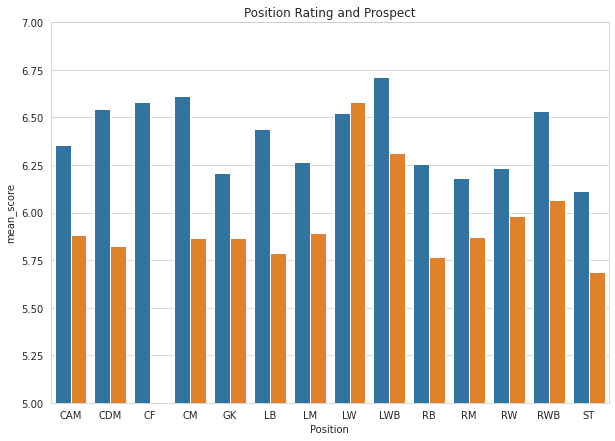

In [31]:
fig, ax = plt.subplots(figsize = (10, 7))

sns.barplot(data = pos_rat_stt,
            x = 'Position',
            y = 'mean_score',
            hue = 'Prospect',
            ax = ax)
plt.gca().legend().set_visible(False)
ax.set_ylim([5, 7])
ax.set_title('Position Rating and Prospect')

- 역시 `Prospect = 1`에서 전반적인 스탯이 더 낮게 나옴
  - `LW`가 특이한 모습을 보이지만 이는 샘플 수가 적은 것에서 기인한다고 판단함
  - 포지션 별로 평균 나이를 뽑아도 되겠지만 위에서 나이에 대한 결론을 미리 냈기 때문에 따로 진행하지 않겠음
- `CF`의 경우 `Prospect = 1`이 없기 때문에 따로 처리할 필요가 있음

<AxesSubplot:>

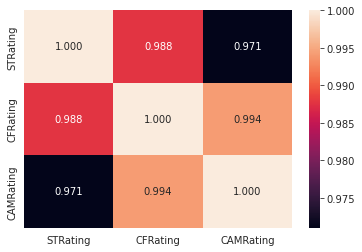

In [32]:
sns.heatmap(data = train.corr().iloc[[train.corr().columns.get_loc('STRating'), train.corr().columns.get_loc('CFRating'), train.corr().columns.get_loc('CAMRating')], [train.corr().columns.get_loc('STRating'), train.corr().columns.get_loc('CFRating'), train.corr().columns.get_loc('CAMRating')]],
            annot = True,
            fmt = '.3f'
)

- `CF`는 `CAM`과의 상관계수가 더 높기 때문에 `CAM`으로 처리하겠음

### 2. Total

In [33]:
pos_tot = train.iloc[:, np.r_[0, 4, train.columns.get_loc('PaceTotal') : train.columns.get_loc('PhysicalityTotal') + 1, -1]]
pos_tot_stt = pos_tot.groupby(['Position', 'Prospect'])['PaceTotal', 'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal'].mean().reset_index()
pos_tot_stt = pos_tot_stt.melt(id_vars = ['Position', 'Prospect'])
pos_tot_stt

<ipython-input-33-f092f39da76e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pos_tot_stt = pos_tot.groupby(['Position', 'Prospect'])['PaceTotal', 'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal'].mean().reset_index()


,Position,Prospect,variable,value
0,CAM,0,PaceTotal,6.110824
1,CAM,1,PaceTotal,5.781114
2,CB,0,PaceTotal,4.893862
3,CB,1,PaceTotal,4.849095
4,CDM,0,PaceTotal,5.289152
...,...,...,...,...
169,RW,1,PhysicalityTotal,2.222222
170,RWB,0,PhysicalityTotal,4.843191
171,RWB,1,PhysicalityTotal,4.535520
172,ST,0,PhysicalityTotal,4.872592


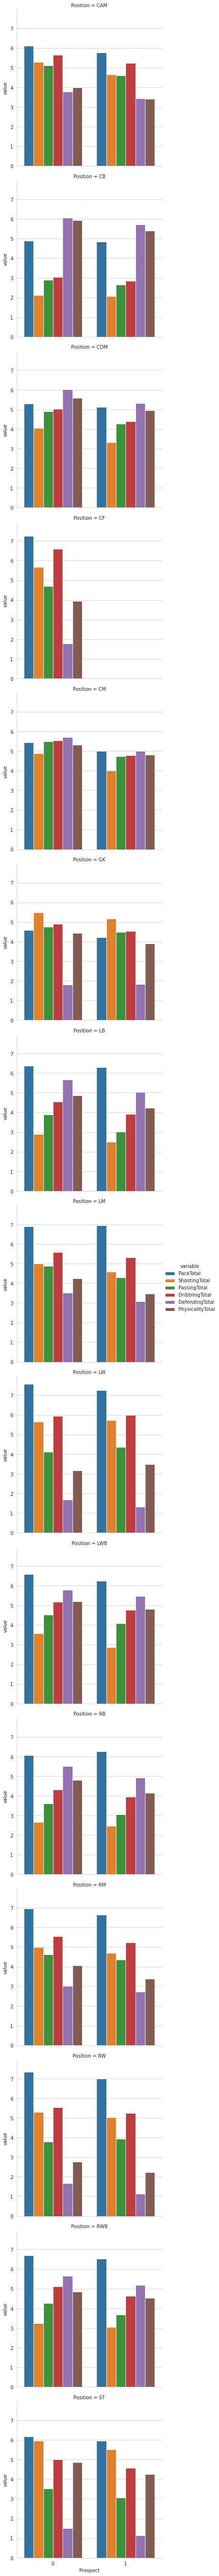

In [35]:
sns.catplot(data = pos_tot_stt,
        x = 'Prospect',
        y = 'value',
        row = 'Position',
        hue = 'variable',
        kind = 'bar'
)

- 역시 `Prospect = 1`에서 전반적으로 낮은 스탯이 나옴



## 선호하는 발과, 포지션 간의 관계
- 위에선 선호하는 발의 비율만을 봤지만, 통념상 왼쪽 측면엔 왼발 선수, 오른쪽 측면엔 오른쪽발 선수를 선호하는 경향이 있다.
- 정말 그런지 살펴보고 그렇다면 선호하는 발에 대한 특성을 추가해준다

In [51]:
train = pd.read_csv('/content/drive/MyDrive/data/train.csv')
temp = train[['ID', 'Position', 'PreferredFoot', 'Prospect']]
temp['Position'].unique()

array(['CB', 'ST', 'RB', 'LB', 'GK', 'CDM', 'CAM', 'CM', 'RM', 'LM',
       'RWB', 'LWB', 'RW', 'CF', 'LW'], dtype=object)

In [65]:
def get_hor_pos(x):
  if x in ['LB', 'LM', 'LWB', 'LW']:
    return 0
  elif x in ['RB', 'RM', 'RWB', 'RW']:
    return 1
  else:
    return 2

temp.loc[:, 'horizontal_pos'] = temp['Position'].apply(lambda x : get_hor_pos(x))
temp = temp.groupby(['horizontal_pos', 'PreferredFoot', 'Prospect'])['ID'].count().to_frame().reset_index().rename(columns = {'ID' : 'counts'})

KeyError: ignored

In [66]:
temp.head()

,horizontal_pos,PreferredFoot,Prospect,counts
0,0,Left,0,207
1,0,Left,1,97
2,0,Right,0,15
3,0,Right,1,7
4,1,Left,1,4


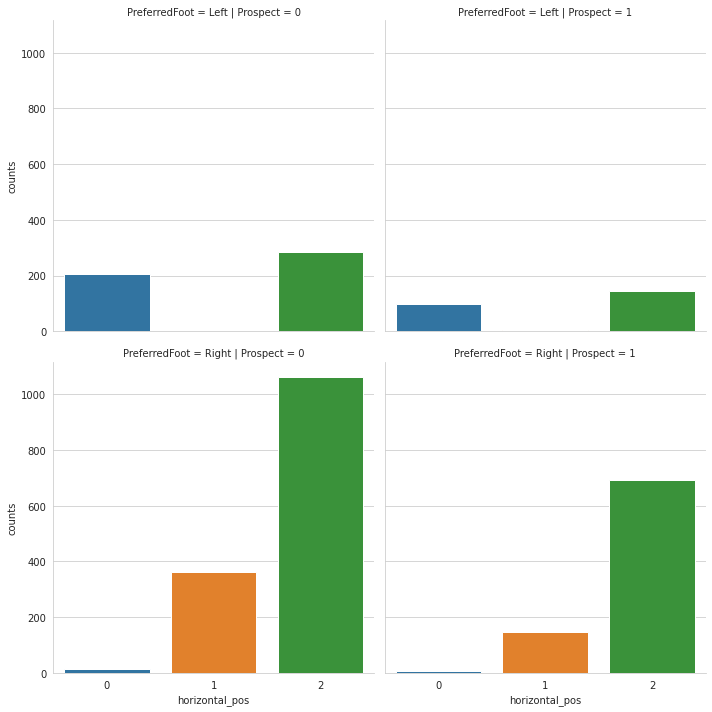

In [68]:
sns.catplot(data = temp,
            x = 'horizontal_pos',
            y = 'counts',
            row = 'PreferredFoot',
            col = 'Prospect',
            kind = 'bar',
            # order = ['LEFT', 'CENTER', 'RIGHT'],  
            )

- 0은 왼쪽, 1은 오른쪽, 2는 중앙을 의미한다
- 포지션이 Center인 경우는 큰 상관이 없지만, 측면에 서는 경우는 관련이 있음을 알 수 있음
- 유망한지 여부와 관련이 없을 수도 있지만 중요한 특성이라고 생각되어 기존 주 포지션을 횡 / 종으로 나누는 것을 생각해봄직함

## 수직적인 위치
- LF, RF, CF는 없는 포지션이다~ 생각하겠음
  - 실제로 앞의 2개는 없고, 뒤의 1개는 매우 적음
  

<AxesSubplot:>

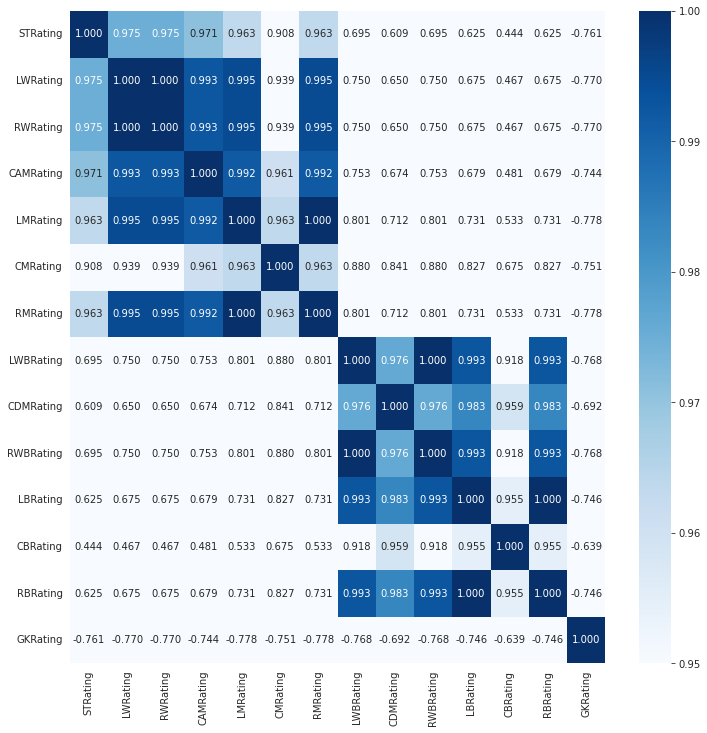

In [39]:
temp = train.corr()
a = temp.columns.get_loc('STRating')
b = temp.columns.get_loc('GKRating')

plt.figure(figsize = (12, 12))
sns.heatmap(data = temp.iloc[np.r_[a:a+2, a+5 : b+1], np.r_[a:a+2, a+5 : b+1]],
            annot = True,
            fmt = '.3f',
            vmin = 0.95,
            vmax = 1,
            cmap = 'Blues'
)

- 가장 충돌이 있을만한 지점들이 윙백이랑 수미, 풀백의 높이정보임
  - 윙백 > 풀백인 건 알겠는데, 수미를 놓으면 애매함
  - 근데 윙백이랑 풀백이 비슷하게 나온단 말임?
  - 수미는 풀백에 더 가까움
- `ST` - `LW, RW, CAM, LM, RM` - `CM` - `LWB/RWB` - `LB/CDM/RB` - `CB` - `GK` 순으로 놓는다


In [55]:
def get_vert_pos(x):
  if x in ['ST']:
    return 6
  elif x in ['LW', 'RW', 'CAM', 'LM', 'RM']:
    return 5
  elif x in ['CM']:
    return 4
  elif x in ['LWB', 'RWB']:
    return 3
  elif x in ['LB',' CDM', 'RB']:
    return 2
  elif x in ['CB']:
    return 1
  else:
    return 0

train['vert_pos'] = train['Position'].apply(lambda x : get_vert_pos(x))
train['hor_pos'] = train['Position'].apply(lambda x : get_hor_pos(x))
train = train.drop('Position', axis = 1)


In [ ]:
train

------------------------------------
## 구분선 & 위 내용 요약
1. `Prospect = 1`에서 레이팅이든 토탈 스탯이든 전반적으로 낮은 경향을 보인다.
  - 이는 유망한 선수들의 나이가 전반적으로 더 어린 데에서 기인한다. 평균으로 생각해도 마찬가지
2. `CF`는 양이 적고, 무조건 `Prospect = 0`이기 때문에 별도의 처리를 해준다
  - `df.corr()`을 돌렸을 때, `ST`와 `CAM`중 `CAM`에 대한 상관계수가 더 높기 때문에 **데이터 처리 시 `CF`는 `CAM`으로 처리한다**
3. 포지션을 횡 / 종으로 나눈다
------------------------------------

# 전처리


In [69]:
train_df = pd.read_csv('/content/drive/MyDrive/data/train.csv', index_col = 'ID')
test_df = pd.read_csv('/content/drive/MyDrive/data/test.csv', index_col = 'ID')

In [70]:
def get_hor_pos(x):
  if x in ['LB', 'LM', 'LWB', 'LW']:
    return 0
  elif x in ['RB', 'RM', 'RWB', 'RW']:
    return 2
  else:
    return 1

def get_vert_pos(x):
  if x in ['ST']:
    return 6
  elif x in ['LW', 'RW', 'CAM', 'LM', 'RM']:
    return 5
  elif x in ['CM']:
    return 4
  elif x in ['LWB', 'RWB']:
    return 3
  elif x in ['LB',' CDM', 'RB']:
    return 2
  elif x in ['CB']:
    return 1
  else:
    return 0

In [71]:
# CF -> CAM
train_df[train_df['Position'] == 'CF'][:] = 'CAM'

# Position -> Horizontal + Vertical
train_df['vert_pos'] = train_df['Position'].apply(lambda x : get_vert_pos(x))
train_df['hor_pos'] = train_df['Position'].apply(lambda x : get_hor_pos(x))
train_df = train_df.drop('Position', axis = 1)


# CF -> CAM
test_df[test_df['Position'] == 'CF'][:] = 'CAM'

# Position -> Horizontal + Vertical
test_df['vert_pos'] = test_df['Position'].apply(lambda x : get_vert_pos(x))
test_df['hor_pos'] = test_df['Position'].apply(lambda x : get_hor_pos(x))
test_df = test_df.drop('Position', axis = 1)

print(train_df.shape, test_df.shape)

(3019, 66) (1626, 65)


<ipython-input-71-f31a4922c47c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_df['Position'] == 'CF'][:] = 'CAM'
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-71-f31a4922c47c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

### LabelEncoder

In [72]:
# # 이거는 모델에 넣기 전에 진행하면 됨 - 먼저 나눠버리면 X축이 뭘 의미하는지 모르게 됨

# foot_order = ['Left', 'Right']
# work_rate_order = ['Low', 'Medium', 'High']

# def column_label_order(df, col, order_lst):

#   LE = LabelEncoder()
#   LE.fit(df[col])
#   LE.classes_ = np.array(order_lst)
#   df[col] = LE.transform(df[col])
#   test_df[col] = LE.transform(test_df[col]) # 테스트 데이터에도 적용함

# column_label_order(train_df, 'PreferredFoot', foot_order)
# column_label_order(train_df, 'AttackingWorkRate', work_rate_order)
# column_label_order(train_df, 'DefensiveWorkRate', work_rate_order)

# train_X = train_df.iloc[:, np.r_[:6, train_df.columns.get_loc('Crossing'):train_df.columns.get_loc('GKReflexes') + 1, -2, -1]]
# train_y = train_df.loc[:, 'Prospect']
# test = test_df.iloc[:, np.r_[:6, test_df.columns.get_loc('Crossing'):test_df.columns.get_loc('GKReflexes') + 1, -2, -1]]

### OneHotEncoder
- DNN을 쓰겠다면 이걸 쓴다

In [ ]:
test_df.head(1)

In [ ]:
# 범주형 데이터들 원핫인코딩
train_X = train_df.iloc[:, np.r_[:3, train_df.columns.get_loc('Crossing'):train_df.columns.get_loc('GKReflexes') + 1]]
train_y = train_df['Prospect']
test = test_df.iloc[:, np.r_[:3, test_df.columns.get_loc('Crossing'):test_df.columns.get_loc('GKReflexes') + 1]]

for i in ['PreferredFoot', 'AttackingWorkRate', 'DefensiveWorkRate', 'vert_pos', 'hor_pos']:

  onehot = pd.get_dummies(train_df[i], # 드롭하지 않은 테이블에서 데이터를 가져오는 것에 유의
                #  drop_first = True,
                prefix = i
                )
  train_X = train_X.join(onehot)

  onehot2 = pd.get_dummies(test_df[i], 
                #  drop_first = True,
                prefix = i
                )
  test = test.join(onehot2)

### 표준화
- 인코딩된 값들은 따로 표준화를 진행하지 않음
- 나이 같은 값은 minMaxScaling이 나은 것 같은데

In [ ]:
# 나머지 모든 데이터를 평균 0, 표준편차 1 사이로 표준화함
# 나중에 정규화(minmax)로도 해보자
ss = StandardScaler()
train_X.iloc[:, np.r_[0:3, train_X.columns.get_loc('Crossing'):train_X.columns.get_loc('GKReflexes') + 1]] = ss.fit_transform(train_X.iloc[:, np.r_[0:3, train_X.columns.get_loc('Crossing'):train_X.columns.get_loc('GKReflexes') + 1]])
# train_X.iloc[:, :train_X.columns.get_loc('GKReflexes') + 1] = ss.transform(train_X.iloc[:, :train_X.columns.get_loc('GKReflexes') + 1])

# 훈련 세트에 적용한 스케일러를 테스트 세트에도 동일하게 적용한다
test.iloc[:, np.r_[:3, test.columns.get_loc('Crossing'):test.columns.get_loc('GKReflexes') + 1]] = ss.transform(test.iloc[:, np.r_[:3, test.columns.get_loc('Crossing'):test.columns.get_loc('GKReflexes') + 1]])

### 정규화


In [73]:
mms = MinMaxScaler()
train_X.iloc[:, np.r_[0:3, train_X.columns.get_loc('Crossing'):train_X.columns.get_loc('GKReflexes') + 1]] = mms.fit_transform(train_X.iloc[:, np.r_[0:3, train_X.columns.get_loc('Crossing'):train_X.columns.get_loc('GKReflexes') + 1]])
# train_X.iloc[:, :train_X.columns.get_loc('GKReflexes') + 1] = ss.transform(train_X.iloc[:, :train_X.columns.get_loc('GKReflexes') + 1])

# 훈련 세트에 적용한 스케일러를 테스트 세트에도 동일하게 적용한다
test.iloc[:, np.r_[:3, test.columns.get_loc('Crossing'):test.columns.get_loc('GKReflexes') + 1]] = mms.transform(test.iloc[:, np.r_[:3, test.columns.get_loc('Crossing'):test.columns.get_loc('GKReflexes') + 1]])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [74]:
train_X.shape, test.shape

((3019, 42), (1626, 42))

In [75]:
# 데이터세트 확인하고 넘어가자
train_X.sample(2)

,Age,Height,Weight,PreferredFoot,AttackingWorkRate,DefensiveWorkRate,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,vert_pos,hor_pos
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0216,0.8,0.409091,0.38,0,1,1,0.608115,0.23077,0.716224,0.722227,0.305882,0.540232,0.511900,0.573169,0.718317,0.691356,0.666667,0.625004,0.679999,0.620690,0.621626,0.243242,0.806455,0.637503,0.545451,0.506027,0.610390,0.772156,0.337210,0.547943,0.466672,0.681162,0.772149,0.776320,0.750000,0.081079,0.068495,0.130434,0.0,0.133338,0,1
TRAIN_2175,1.0,0.409091,0.46,1,2,1,0.797303,0.76923,0.702703,0.749997,0.788231,0.793105,0.690478,0.780488,0.661978,0.777774,0.790122,0.800002,0.853330,0.706891,0.743247,0.675674,0.693551,0.699995,0.606059,0.795182,0.662339,0.253164,0.790696,0.684932,0.853341,0.753624,0.392400,0.381584,0.394735,0.094600,0.054801,0.057963,0.0,0.026670,5,1


In [76]:
test.sample(2)

,Age,Height,Weight,PreferredFoot,AttackingWorkRate,DefensiveWorkRate,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,vert_pos,hor_pos
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TEST_0332,0.6,0.318182,0.36,0,1,1,0.594594,0.46154,0.648654,0.486115,0.494120,0.609200,0.464289,0.451219,0.267604,0.580249,0.691362,0.687498,0.479997,0.431029,0.621626,0.418916,0.645159,0.649997,0.454539,0.530125,0.454541,0.632914,0.558144,0.547943,0.653339,0.579710,0.708857,0.631581,0.592102,0.02703,0.000000,0.057963,0.094593,0.119997,2,0
TEST_0804,0.8,0.363636,0.30,1,1,1,0.418927,0.64835,0.689194,0.458333,0.423527,0.586211,0.428567,0.390249,0.380283,0.580249,0.604939,0.499995,0.599996,0.362063,0.689187,0.378379,0.532256,0.512499,0.318176,0.578311,0.467534,0.227844,0.662790,0.383568,0.693334,0.507247,0.227840,0.223691,0.197367,0.00000,0.013694,0.130434,0.081074,0.013329,6,1


# 모델 적용



## 1. 랜덤 포레스트

- HPO : RandomizedSearchCV

In [ ]:
# 하이퍼 파라미터 파라미터 튜닝하고 ㄱ
clf = RandomForestClassifier()


params_rs = {'max_depth' : list(range(5, 10)),
          'n_estimators' : list(range(50, 500)),
          'min_sample_splits' : list(range(2, 10))
          }

# RandomizedSearch
model = RandomizedSearchCV(estimator = clf,
                           param_distributions = params_rs,
                           n_iter = 30,
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 1,
                          random_state = 0)

model.fit(train_X, train_y)

In [ ]:
model.best_params_

- HPO : BayesSearchCV

In [ ]:
# clf.get_params().keys() # 어떤 하이퍼파라미터를 사용할 수 있는지 나옴

In [ ]:
clf = RandomForestClassifier(max_depth = 10, bootstrap = True)

params_bs = {
          'n_estimators' : tuple(range(50, 501, 50)), # 트리의 수가 1자리 단위까지 중요한 건 아니니까 간격을 적당히 주자
          'max_features' : ('auto', 'log2', None)
          }

# BayesSearch
model = BayesSearchCV(estimator = clf,
                           search_spaces = params_bs,
                           n_iter = 20,
                           cv = 3,
                           n_jobs = -1, 
                        verbose = 2,
                          random_state = 0)

In [ ]:
model.fit(train_X, train_y)

In [ ]:
# print(model.cv_results_['params'], model.cv_results_['mean_test_score'])
print(model.best_params_), print(model.best_score_)

In [ ]:
# 파라미터가 어떻게 수렴되는지 보고 싶음
temp = pd.DataFrame(model.cv_results_['params']).merge(pd.DataFrame(model.cv_results_['mean_test_score'], columns = ['mean_test_score']), left_index = True, right_index = True)
temp.tail(20)

In [ ]:
sns.scatterplot(data = temp, x = temp.index, y= 'n_estimators')

In [ ]:
pred = model.predict(test)
pred

In [ ]:
submit = pd.DataFrame({'Prospect' : pred}, index = test.index)
submit
submit.to_csv('221121_RF_Bayes_1.csv')

In [ ]:
# Ordinial Encoder를 써본다든가
# Age Height Weight를 써본다든가
# 뭐 등등이 있겠쥬?

## 2. DNN
- HPO까지 해보겠음
- RF는 LabelEncoder를 쓰지만 DNN은 One-Hot-Encoder를 쓴다

In [ ]:
# # 함수로 모델을 만들 경우 다시 실행했을 때 작동을 안해서 클래스로 구현해봄
# class myDNN(keras_tuner.HyperModel):
#   def build(self, hp):
#     model = tf.keras.Sequential()

#     model.add(layers.Input(shape = sub_X.shape[1]))
#     model.add(layers.Dense(hp.Choice('Units', [32, 64, 128, 256, 512, 1024]), activation = 'relu'))
#     model.add(layers.Dense(hp.Choice('Units', [16, 32, 64, 128, 256, 512]), activation = 'relu'))
#     model.add(layers.Dense(1, activation = 'sigmoid'))
#     model.compile(optimizer = 'adam', 
#                   loss = 'binary_crossentropy',
#                   # loss = 'mse',
#                   metrics = ['Accuracy'])
    
#     return model

#   def fit(self, hp, model, x, y, validation_data = True, **kwargs):
#     if validation_data:
#       sub_X, val_X, sub_y, val_y = train_test_split(train_X, train_y, 
#                                                     test_size = 0.2, 
#                                                     random_state = 0, 
#                                                     stratify = train_y)
#       validation_data = (val_X, val_y)

#     return model.fit(
#         sub_X, sub_y,
#         shuffle = hp.Boolean("shuffle"),
#         validation_data = validation_data,
#         **kwargs,
#     )

# tuner = keras_tuner.RandomSearch(
#     myDNN(),
#     objective = 'val_loss',
#     max_trials = 10,
# )

# tuner.search(train_X, train_y, epochs = 10, validation_data = (val_X, val_y), verbose = 2)

# best_hp = tuner.get_best_hyperparameters()[0]
# model = hypermodel.build(best_hp)
# hist = hypermodel.fit(best_hp, model, train_X, train_y, epochs =1)

In [77]:
sub_X, val_X, sub_y, val_y = train_test_split(train_X, train_y, test_size = 0.2, random_state = 0, stratify = train_y)
sub_X.shape, val_X.shape, sub_y.shape, val_y.shape

def get_model(hp):

  # 하이퍼파라미터
  units = hp.Choice('Units', [128, 256, 512])
  num_of_layer = hp.Int('Layers', 1, 4)
  activation = hp.Choice('AF', ['relu', 'tanh', 'sigmoid'])
  dropout_rate = hp.Float('Dropout_Rate', 0, 0.7, step = 0.1)

  # 모델
  model = tf.keras.Sequential()
  model.add(layers.Input(shape = sub_X.shape[1]))

  for i in range(num_of_layer):
    model.add(layers.Dense(units // (2 ** i), activation = activation))  
    model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                # loss = 'mse',
                metrics = ['Accuracy'])
  
  return model

In [78]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.75,
                              patience = 3,
                              min_lr = 0.0001)

es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, restore_best_weights = True)

In [ ]:
# RandomSearch # 더 좋은 방법들이 있기 때문에 사용하지 않겠음
# tuner = keras_tuner.RandomSearch(get_model, 
#                                  objective = 'val_loss', 
#                                  max_trials = 30, 
#                                  overwrite = True)

In [ ]:
# BayesianOptimization
tuner = keras_tuner.BayesianOptimization(get_model, 
                                            objective = 'val_loss', 
                                            max_trials = 30, 
                                            overwrite = True)

In [79]:
# HyperBand
tuner = keras_tuner.Hyperband(get_model, 
                              objective = 'val_loss', 
                              max_epochs = 81,
                              factor = 3,
                              overwrite = True,
                              seed = 0)

In [80]:
sub_X, val_X, sub_y, val_y = train_test_split(train_X, train_y, test_size = 0.2, random_state = 0, stratify = train_y)

tuner.search(sub_X, sub_y, 
             epochs = 20, # Hyperband에서는 쓰지 않음
             validation_data = (val_X, val_y), 
             verbose = 2,
             callbacks = [reduce_lr, es]
             )

tuner.get_best_hyperparameters()[0]

Trial 211 Complete [00h 00m 17s]
val_loss: 0.44728749990463257

Best val_loss So Far: 0.4436894655227661
Total elapsed time: 00h 12m 22s


In [ ]:
# 모델을 얻고 바로 끝내면 되는 거 아님?
# model = tuner.get_best_model(num_models = 1)
# model.summary()

In [82]:
tuner.results_summary(num_trials = 1)
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
Units: 512
Layers: 1
AF: tanh
Dropout_Rate: 0.2
tuner/epochs: 81
tuner/initial_epoch: 27
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0118
Score: 0.4436894655227661
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               22016     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


In [83]:
# 데이터셋을 바꿔봄 - 이걸로 과적합을 방지할 수 있을지도?
# sub_X, val_X, sub_y, val_y = train_test_split(train_X, train_y, test_size = 0.2, random_state = 1, stratify = train_y)

model.fit(sub_X, sub_y, 
             epochs = 50, 
             validation_data = (val_X, val_y), 
             verbose = 2,
             callbacks = [reduce_lr, es])

Epoch 1/50
76/76 - 1s - loss: 0.6355 - Accuracy: 0.6398 - val_loss: 0.5776 - val_Accuracy: 0.6656 - lr: 0.0010 - 964ms/epoch - 13ms/step
Epoch 2/50
76/76 - 0s - loss: 0.5676 - Accuracy: 0.7077 - val_loss: 0.5283 - val_Accuracy: 0.7765 - lr: 0.0010 - 186ms/epoch - 2ms/step
Epoch 3/50
76/76 - 0s - loss: 0.5132 - Accuracy: 0.7528 - val_loss: 0.4801 - val_Accuracy: 0.7781 - lr: 0.0010 - 209ms/epoch - 3ms/step
Epoch 4/50
76/76 - 0s - loss: 0.4974 - Accuracy: 0.7710 - val_loss: 0.4884 - val_Accuracy: 0.7831 - lr: 0.0010 - 192ms/epoch - 3ms/step
Epoch 5/50
76/76 - 0s - loss: 0.4913 - Accuracy: 0.7731 - val_loss: 0.4606 - val_Accuracy: 0.7815 - lr: 0.0010 - 209ms/epoch - 3ms/step
Epoch 6/50
76/76 - 0s - loss: 0.4744 - Accuracy: 0.7752 - val_loss: 0.5314 - val_Accuracy: 0.7318 - lr: 0.0010 - 232ms/epoch - 3ms/step
Epoch 7/50
76/76 - 0s - loss: 0.4701 - Accuracy: 0.7739 - val_loss: 0.4511 - val_Accuracy: 0.7864 - lr: 0.0010 - 231ms/epoch - 3ms/step
Epoch 8/50
76/76 - 0s - loss: 0.4739 - Accuracy

In [84]:
pred = np.round_(model.predict(test)).flatten()
pred

51/51 [==============================] - 0s 1ms/step


array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [ ]:
submit = pd.DataFrame({'Prospect' : pred}, index = test.index)

submit.to_csv('HB_ValLoss_0.4662.csv')

# 3. XGBoost 모델

- 똑같이 트리를 쓰니까 여기도 `LabelEncoder` 를 사용함

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# 실사용법은 sklearn과 동일함
xgb = XGBClassifier()

params_bs = {
          'n_estimators' : tuple(range(100, 501, 100)), # 트리의 수가 1자리 단위까지 중요한 건 아니니까 간격을 적당히 주자
          'max_depth' : (1, 50, 1),
          'learning_rate': (0.01, 1.0, 'log-uniform'),
          'gamma': (1e-9, 0.5, 'log-uniform'),
          }

fit_params = {
    'early_stopping_rounds': 10,
    'eval_set':[(train_X, train_y)],
    'verbose': 2,
}

# BayesSearch
model = BayesSearchCV(estimator = xgb,
                      search_spaces = params_bs,
                      fit_params = fit_params,
                           n_iter = 20,
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 2,
                          random_state = 0)

model.fit(train_X, train_y)

In [ ]:
print(model.best_params_), print(model.best_score_)

In [ ]:
pred = model.predict(test)
pred

In [ ]:
submit = pd.DataFrame({'Prospect' : pred}, index = test.index)
submit
submit.to_csv('XGBoost_7863.csv')